In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import plotly as py
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

<AxesSubplot:>

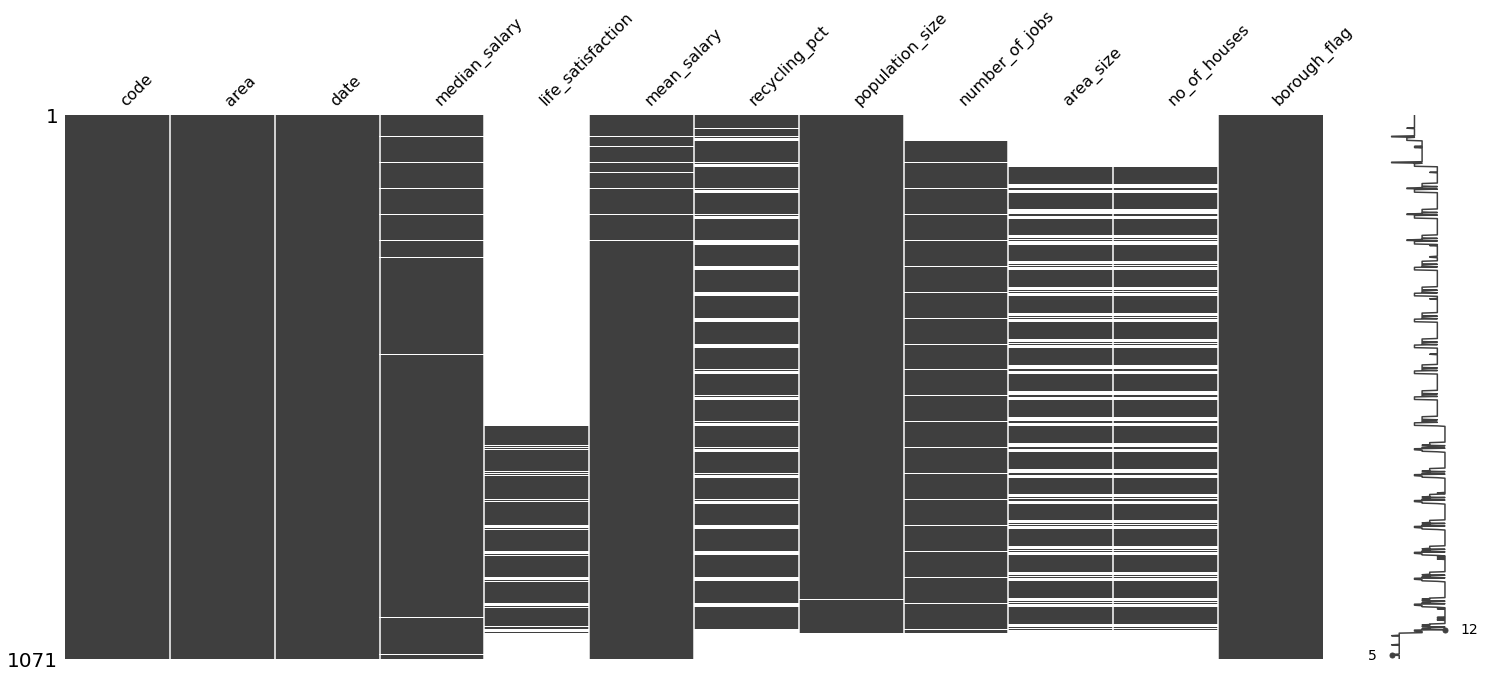

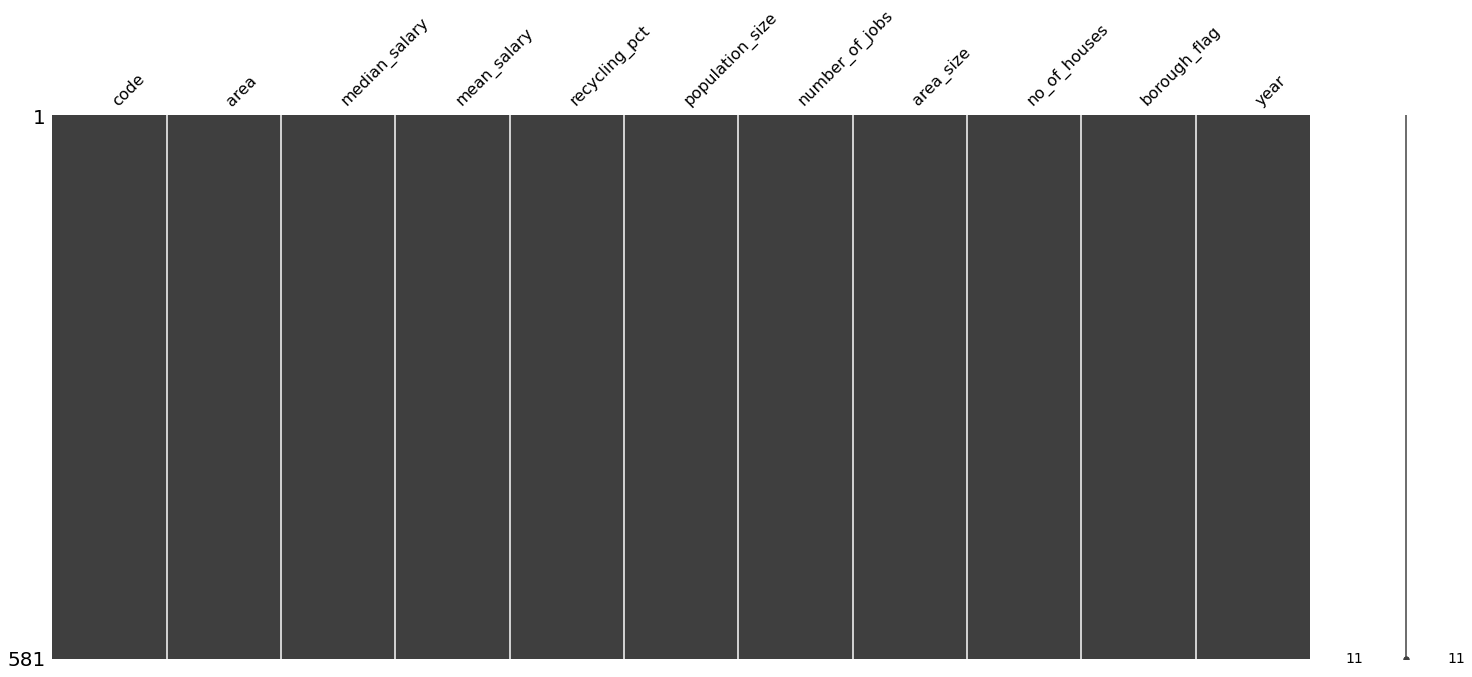

In [2]:
# Load in housing data

house_data = pd.read_csv("housing_in_london/housing_in_london_yearly_variables.csv") #billy you need to cut sub 2001 data?
house_data.dtypes # Lets check datatypes. FOr some reason mean salary and recylcing percentages are objects not floats. Lets change that!
house_data.mean_salary = house_data.mean_salary.apply(pd.to_numeric, errors='coerce') #Drop strings and make float
house_data.recycling_pct = house_data.recycling_pct.apply(pd.to_numeric, errors='coerce') #Drop strings and make float
house_data.area.unique() #Drop non boroughs
house_data.date.unique() #Match election dates
msno.matrix(house_data)

# Let's first drop the entire "life_satisfaction" column here as it is missing lots of values. We can then remove individual rows that contain a "NaN.
house_data.drop(columns = ["life_satisfaction"], inplace = True)

# Change dates to just years
house_data['year'] = house_data['date'].str.split('-').str[0]
house_data.drop(columns = ["date"], inplace = True)

house_data.dropna(inplace = True)
house_data=house_data[(house_data.area != 'london') & (house_data.area != 'england' )]

msno.matrix(house_data)
#Done


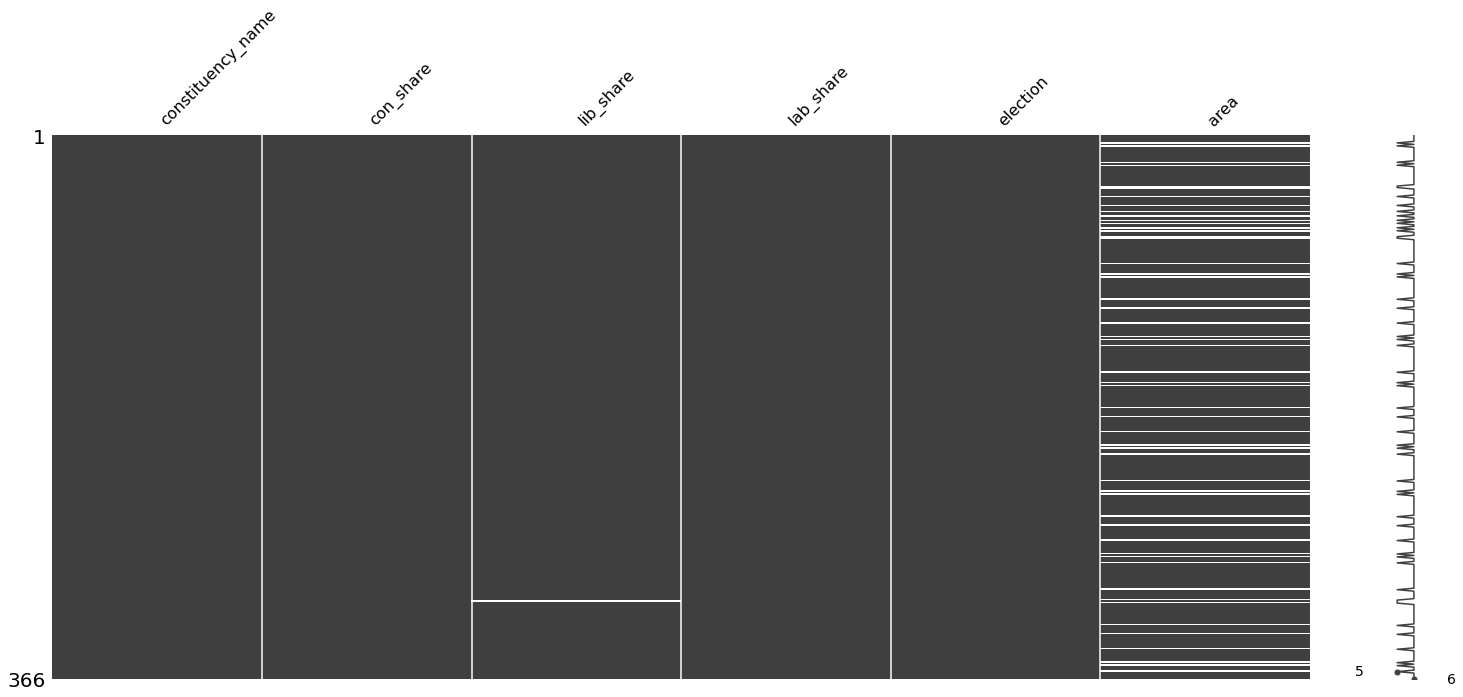

In [3]:
# Load in election data

election_data = pd.read_csv("1918-2019election_results.csv",encoding = "ISO-8859-1") #Needs encoding specified or wont read file
election_data = election_data[election_data.election>"2001"] #this now matches other data
election_data = election_data[election_data["country/region"]=='London'] #Only London
election_data = election_data[["constituency_name", "con_share", "lib_share", "lab_share", "election"]] # We want the share (percentage of votes rather than raw number)

#Load in constituency list for conversion

constituencies = pd.read_csv("constituencies_boroughs.csv")
dict_constituencies_boroughs = dict(constituencies.values)

#Conversion from constituency to area

election_data['area']= election_data["constituency_name"].map(dict_constituencies_boroughs)
election_data['area']= election_data.area.str.lower() #lower case for now so it works on join
msno.matrix(election_data)
#Still some NaNs will clean this up in future work,for now just drop!
election_data.dropna(inplace = True)

#Determine winner by year

def determine_winner(row):
    vote_shares = [row.con_share, row.lib_share, row.lab_share]
    win = np.argmax(vote_shares)
    if win == 0:
        winner = "con"
    elif win == 1:
        winner = "lib"
    elif win == 2:
        winner = "lab"
    return winner
        
election_data["winner"] = election_data.apply(lambda row: determine_winner(row), axis=1)

In [4]:
# Load in geo/polygon data

geo_data = gpd.read_file('BoroughFiles/London_Borough_Excluding_MHW.shp')

In [5]:
# Do this quickly, optimise later

def add_election(row):
    if int(row.year) < 2006:
        election = "2005"
        return election
    elif int(row.year) < 2011:
        election = "2010"
        return election
    elif int(row.year) < 2016:
        election = "2015"
        return election
    elif int(row.year) < 2018:
        election = "2017"
        return election
    else:
        election = "2019"
        return election
        
house_data["election"] = house_data.apply(lambda row: add_election(row), axis=1)

In [6]:
# Do an inner(?) merge here

#combined_data = pd.merge(election_data, house_data, how="inner", on=["area", "election"])
election_data.reset_index(inplace=True, drop=True)
# election_data = election_data.astype({'area': 'string', 'election': 'string'})
# election_data.area.str.strip() 
# election_data.election.str.strip()
# house_data.area.str.strip()
# house_data.election.str.strip()
house_data.reset_index(inplace=True, drop=True)
# house_data = house_data.astype({'area': 'string', 'election': 'string'})
combined_data = pd.merge(election_data, house_data, how="outer", on=["area", "election"])

#Drop Nan
combined_data.dropna(inplace=True)

In [7]:
#No, we do need some kind of dummy data. Think of a smarter way to do this in future

# Some manual adds of dummy data for the sake of Tableau plotting

#2019 dummy data
bexley_2019_dummy = combined_data.iloc[938,:]
bexley_2019_dummy[["election","winner","year"]] = ["2019","con", "2018"]
redbridge_2019_dummy = combined_data.iloc[956,:]
redbridge_2019_dummy[["election","winner","year"]] = ["2019","lab", "2018"]
kingston_upon_thames_2019_dummy = combined_data.iloc[1017,:]
kingston_upon_thames_2019_dummy[["election","winner","year"]] = ["2019","lib", "2018"]
merton_2019_dummy = combined_data.iloc[1027,:]
merton_2019_dummy[["election","winner","year"]] = ["2019","con", "2018"]

westminster_2005_dummy = combined_data.iloc[590,:]
westminster_2005_dummy[["election","winner","year"]] = ["2005","con", "2004"]
kensington_and_chelsea_2005_dummy = combined_data.iloc[540,:]
kensington_and_chelsea_2005_dummy[["election","winner","year"]] = ["2005","con", "2004"]
hammersmith_and_fulham_2005_dummy = combined_data.iloc[496,:]
hammersmith_and_fulham_2005_dummy[["election","winner","year"]] = ["2005","con", "2004"]

dummy_df = pd.DataFrame([bexley_2019_dummy, redbridge_2019_dummy, kingston_upon_thames_2019_dummy, merton_2019_dummy, westminster_2005_dummy, kensington_and_chelsea_2005_dummy, hammersmith_and_fulham_2005_dummy])
combined_data = pd.concat([combined_data,dummy_df])

#combined_data.reset_index(inplace=True, drop=True) # Do I need this? Yeah maybe, you added a bug somewhere ... noworries, fix tomorrow!

/Users/billydawton/opt/anaconda3/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/Users/billydawton/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()
/Users/billydawton/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

In [8]:
#BILLY NEED TO CHECK THIS, WHY IS CROSS VAL ACC LOWER?

# Here you are going to predict some elections. 2017 and 2019
#Lets start with 2019

data_for_ml = combined_data.drop(columns = ['constituency_name', 'con_share', 'lib_share', 'lab_share', 'election',
       'area', 'code', 'borough_flag', 'year'] ,inplace = False)

#Split post-2019 and pre-2019 everything pre-2019 election results is train basically
pre = data_for_ml[combined_data.election != "2019"] #No "election" column in ML dataset, but can use information from original combined_dataset
post = data_for_ml[combined_data.election == "2019"]

# Lets begin with simple RF, then we can test out alternative like SVM (dont forget fit transform with SVM though!)

# model = RandomForestClassifier(random_state=1,n_jobs=-1)

#Lets do k-fold on train to check model is consistent
#Add undersampling later! (And then remove stratified k-fold cos wont need it after undersampling)

x_pre = np.asarray(pre.drop(columns=["winner"]).astype(float)) #wierd indexing problem here. Same as the reset index earlier, not solved though. Annyoing but ok
y_pre = np.asarray(pre.winner)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
conf_mat = np.zeros([3,3])
accuracy_list = []
for train_index, test_index in skf.split(x_pre, y_pre):
    x_train_fold, x_test_fold = x_pre[train_index], x_pre[test_index]
    y_train_fold, y_test_fold = y_pre[train_index], y_pre[test_index]
    model = RandomForestClassifier(random_state=1,n_jobs=-1) #not necessary? but for peace of mind do this
    model.fit(x_train_fold, y_train_fold)
    #accuracy score
    accuracy_list.append(model.score(x_test_fold, y_test_fold))
    # prediction with test data
    y_pred_fold = model.predict(x_test_fold)
    # generate confusion matrix
    conf_mat_fold = confusion_matrix(y_test_fold, y_pred_fold)
    conf_mat += conf_mat_fold

#Lets quickly get some predicitons for the dataset/tableau NOT UNDERSAMPLED OR ANYTHING YET

x_post = np.asarray(post.drop(columns=["winner"]).astype(float)) #wierd indexing problem here. Same as the reset index earlier, not solved though. Annyoing but ok
y_post = np.asarray(post.winner)
conf_mat = np.zeros([3,3])
model = RandomForestClassifier(random_state=1,n_jobs=-1) #not necessary? but for peace of mind do this
model.fit(x_pre, y_pre)
#accuracy score
acc = model.score(x_post, y_post)
# prediction with test data
y_pred = model.predict(x_post)
# generate confusion matrix
conf_mat = confusion_matrix(y_post, y_pred)


#Lets add the pres to dataset/tableau
predicted_data = pd.DataFrame(combined_data[combined_data.election == "2019"])
predicted_data.election[predicted_data.election == "2019"] = "2019_pred"
predicted_data.winner = y_pred
combined_data = pd.concat([combined_data,predicted_data])

print(accuracy_list)
print(acc)

[0.7307692307692307, 0.6875, 0.7355769230769231, 0.7307692307692307, 0.7536231884057971]
0.9285714285714286


/var/folders/zz/xjwbp7f92l99p4r8jrpdq7fr0000gn/T/ipykernel_28073/691462036.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_data.election[predicted_data.election == "2019"] = "2019_pred"


In [9]:
combined_data['area'].unique() #How many boroughs areas?
combined_data['constituency_name'].unique() #How many constituencies?

# It takes a long time to make the call, so lets just get the codes first, then manually add the missing ones, then do the geocoding
geolocator = Nominatim(user_agent="london")
dict_area_coord = {}
dict_constituency_coord = {}
dict_lat_postcode = {}

# Get area(borough) codes
for area in combined_data['area'].unique():
    dict_area_coord[area] = geolocator.geocode(query=area, country_codes="gb", addressdetails = True) #Very important to specify country, otherwise missclassify, and also not find some

    #This loads the wrong Tower Hamelts, so for now let`s correct that manually
dict_area_coord["tower hamlets"] = geolocator.geocode("London Borough of Tower Hamlets")

# Get constituency codes
for constituency in combined_data['constituency_name'].unique():
    if constituency not in ("Harrow East" , "Lewisham East", "Cities Of London And Westminster"):  #There are other locations that return nothing, but these two in particular made the geolocator trip out for some reason
        dict_constituency_coord[constituency] = geolocator.geocode(query=constituency, country_codes="gb", addressdetails = True) #Very important to specify country, otherwise missclassify, and also not find some
    elif constituency == "Harrow East":
        dict_constituency_coord[constituency] = geolocator.geocode(query="HA3 5FE", country_codes="gb", addressdetails = True)#Dummy Harrow East Postcode
    elif constituency == "Lewisham East":
        dict_constituency_coord[constituency] = geolocator.geocode(query="BR1 4LA", country_codes="gb", addressdetails = True)#Dummy Lewisham East Postcode
    elif constituency == "Cities Of London And Westminster":
        dict_constituency_coord[constituency] = geolocator.geocode(query="EC1A 2AE", country_codes="gb", addressdetails = True)#Dummy City Of London Postcode
#We want constituency coords    


combined_data['coords'] = combined_data['constituency_name'].map(dict_constituency_coord) #If it turns out we can drop this safely, can you rewrite code to just remove coords from discussion?
#Drop rows with empty values
combined_data.dropna(subset=['coords'], inplace=True)  

combined_data['latitude'] = combined_data['coords'].apply(lambda x: x[1][0])
combined_data['longtitude'] = combined_data['coords'].apply(lambda x: x[1][1])

In [10]:
area_postcode_frame = pd.DataFrame({'area' : combined_data['area'].unique()})

# Get constituency codes
# for constituency in area_postcode_frame:
#     if constituency not in ("Harrow East" , "Lewisham East", "Cities Of London And Westminster"):  #There are other locations that return nothing, but these two in particular made the geolocator trip out for some reason
#         dict_area_coord[constituency] = geolocator.geocode(query=constituency, country_codes="gb", addressdetails = True) #Very important to specify country, otherwise missclassify, and also not find some
#     elif constituency == "Harrow East":
#         dict_area_coord[constituency] = geolocator.geocode(query="HA3 5FE", country_codes="gb", addressdetails = True)#Dummy Harrow East Postcode
#     elif constituency == "Lewisham East":
#         dict_area_coord[constituency] = geolocator.geocode(query="BR1 4LA", country_codes="gb", addressdetails = True)#Dummy Lewisham East Postcode
#     elif constituency == "Cities Of London And Westminster":
#         dict_area_coord[constituency] = geolocator.geocode(query="EC1A 2AE", country_codes="gb", addressdetails = True)#Dummy City Of London Postcode
#We want constituency coords    

for constituency in area_postcode_frame:
    dict_area_coord[constituency] = geolocator.geocode(query=constituency, country_codes="gb", addressdetails = True) #Very important to specify country, otherwise missclassify, and also not find some



area_postcode_frame['coords'] = area_postcode_frame['area'].map(dict_area_coord) #If it turns out we can drop this safely, can you rewrite code to just remove coords from discussion?
#Drop rows with empty values
combined_data.dropna(subset=['coords'], inplace=True)  

area_postcode_frame['latitude'] = area_postcode_frame['coords'].apply(lambda x: x[1][0])
area_postcode_frame['longtitude'] = area_postcode_frame['coords'].apply(lambda x: x[1][1])

In [11]:
#We also want postcodes (rewrite this later - in fact rewrite all of this later)

for lat,long in zip(area_postcode_frame.latitude.unique(), area_postcode_frame.longtitude.unique()):
    location = geolocator.reverse("{}, {}".format(lat,long))
    postcode = location.raw['address']['postcode']
    dict_lat_postcode[lat] = postcode # We only need one dic, as we can just map to the latitiude column
    
area_postcode_frame['postcode'] = area_postcode_frame['latitude'].map(dict_lat_postcode) #Only need to map to latitude


In [12]:
constituency_postcode_frame = pd.DataFrame({'constituency_name' : combined_data['constituency_name'].unique()})

# Get constituency codes
for constituency in constituency_postcode_frame:
    if constituency not in ("Harrow East" , "Lewisham East", "Cities Of London And Westminster"):  #There are other locations that return nothing, but these two in particular made the geolocator trip out for some reason
        dict_constituency_coord[constituency] = geolocator.geocode(query=constituency, country_codes="gb", addressdetails = True) #Very important to specify country, otherwise missclassify, and also not find some
    elif constituency == "Harrow East":
        dict_constituency_coord[constituency] = geolocator.geocode(query="HA3 5FE", country_codes="gb", addressdetails = True)#Dummy Harrow East Postcode
    elif constituency == "Lewisham East":
        dict_constituency_coord[constituency] = geolocator.geocode(query="BR1 4LA", country_codes="gb", addressdetails = True)#Dummy Lewisham East Postcode
    elif constituency == "Cities Of London And Westminster":
        dict_constituency_coord[constituency] = geolocator.geocode(query="EC1A 2AE", country_codes="gb", addressdetails = True)#Dummy City Of London Postcode
#We want constituency coords    

constituency_postcode_frame['coords'] = constituency_postcode_frame['constituency_name'].map(dict_constituency_coord) #If it turns out we can drop this safely, can you rewrite code to just remove coords from discussion?
#Drop rows with empty values
combined_data.dropna(subset=['coords'], inplace=True)  

constituency_postcode_frame['latitude'] = constituency_postcode_frame['coords'].apply(lambda x: x[1][0])
constituency_postcode_frame['longtitude'] = constituency_postcode_frame['coords'].apply(lambda x: x[1][1])

In [13]:
#We also want postcodes (rewrite this later - in fact rewrite all of this later)

for lat,long in zip(constituency_postcode_frame.latitude.unique(), constituency_postcode_frame.longtitude.unique()):
    location = geolocator.reverse("{}, {}".format(lat,long))
    postcode = location.raw['address']['postcode']
    dict_lat_postcode[lat] = postcode # We only need one dic, as we can just map to the latitiude column
    
constituency_postcode_frame['postcode'] = constituency_postcode_frame['latitude'].map(dict_lat_postcode) #Only need to map to latitude


In [20]:
interim_final_combined_data = pd.merge(combined_data, constituency_postcode_frame[["constituency_name","postcode"]], how="outer", on=["constituency_name"])
final_combined_data = pd.merge(interim_final_combined_data, area_postcode_frame[["area","postcode"]], how="outer", on=["area"])

#Drop Nan
final_combined_data.dropna(inplace=True)

KeyError: 'constituency_name'

In [15]:
final_combined_data.dtypes

constituency_name     object
con_share            float64
lib_share            float64
lab_share            float64
election              object
area                  object
winner                object
code                  object
median_salary        float64
mean_salary          float64
recycling_pct        float64
population_size      float64
number_of_jobs       float64
area_size            float64
no_of_houses         float64
borough_flag         float64
year                  object
coords                object
latitude             float64
longtitude           float64
postcode              object
dtype: object

In [17]:
# Last step

area_polygon_dict = dict(zip(geo_data['NAME'].str.lower(), geo_data['geometry']))

final_combined_data['geometry'] = final_combined_data['area'].map(area_polygon_dict)

gdata = gpd.GeoDataFrame(final_combined_data.drop(["coords"],axis = 1)) #Can you get away with only dropping coords here? YES
gdata.set_crs("epsg:27700",inplace=True) #This line is importtant, Billy explain what this is and how you obtained it! Basically its encoding infrormation and if you dont include it wont work

gdata.to_file('LondonFiles.shp', driver='ESRI Shapefile') #not sure we need the driver, check. THIS IS FINAL OUTPUT FOR TABLEAU

/Users/billydawton/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/var/folders/zz/xjwbp7f92l99p4r8jrpdq7fr0000gn/T/ipykernel_28073/1182376095.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdata.to_file('LondonFiles.shp', driver='ESRI Shapefile') #not sure we need the driver, check. THIS IS FINAL OUTPUT FOR TABLEAU
